In [1]:
import vtk
import matplotlib.pyplot as plt
import numpy as np
import os
from vtk import vtkUnstructuredGridReader
from vtk import vtkXMLUnstructuredGridReader
from vtk.util import numpy_support as VN
from vtk.util.numpy_support import vtk_to_numpy
from scipy.spatial import KDTree
from scipy.interpolate import RegularGridInterpolator
import pygmt
os.chdir("../postprocessing_scripts")
import LPO_postprocessing as LPO
os.chdir("../main_figures")

# Extract ASPECT particle output

In [2]:
model_path = "../ASPECT_models/WET_LPO_STOKES/"
# model_path = "../ASPECT_models/DRY_LPO_STOKES/"
particle_dir_path = model_path + "particles/"
particle_files = np.sort(os.listdir( particle_dir_path ))
t_step = 7

if 'particle_solution' in locals():
    del particle_solution, total_lpo_e1_axis

for file in particle_files:
    if file[-4:-1] == '.vt' and file[10:15] == str(t_step).zfill(5):

        file_path = os.path.join(particle_dir_path, file)
        reader = vtkXMLUnstructuredGridReader()
        reader.SetFileName(file_path)
        reader.Update()
        data = reader.GetOutput()
        points = data.GetPoints()
        x = vtk_to_numpy(points.GetData())
        lpo_e1_axis = vtk_to_numpy(data.GetPointData().GetArray('lpo elastic axis e1'))

        if 'particle_solution' in locals():
            particle_solution = np.concatenate( (particle_solution, x) )
            total_lpo_e1_axis = np.concatenate( (total_lpo_e1_axis, lpo_e1_axis) )
        else:
            particle_solution = x
            total_lpo_e1_axis = lpo_e1_axis

# Extract ASPECT Field Data

In [3]:
sol_dir_path = model_path + "solution/"
solutions = np.sort(os.listdir( sol_dir_path ))
t_step = 0

if 'pos_solution' in locals():
    del pos_solution, litho_total, crust_total, visc_raw_total

stress_second_invariant = np.empty(0)
for soln in solutions:
    if soln[-4:-1] == '.vt' and soln[9:14] == str(t_step).zfill(5):
        
        file_path = os.path.join(sol_dir_path, soln)
        reader = vtkXMLUnstructuredGridReader()
        reader.SetFileName(file_path)
        reader.Update()
        data = reader.GetOutput()
        points = data.GetPoints()
        x = vtk_to_numpy(points.GetData())
        litho = vtk_to_numpy(data.GetPointData().GetArray('Base_Subducting'))
        crust = vtk_to_numpy(data.GetPointData().GetArray('Crust'))
        visc_raw = vtk_to_numpy(data.GetPointData().GetArray('viscosity'))
        sigma_ii = vtk_to_numpy(data.GetPointData().GetArray('stress_second_invariant'))
        
        if 'pos_solution' in locals():
            pos_solution = np.concatenate( (pos_solution, x) )
            litho_total = np.concatenate( (litho_total, litho) )
            visc_raw_total = np.concatenate( (visc_raw_total, visc_raw) )
            crust_total = np.concatenate( (crust_total, crust) )
        else:
            pos_solution = x
            litho_total = litho
            visc_raw_total = visc_raw
            crust_total = crust
            
        stress_second_invariant = np.concatenate( (stress_second_invariant, sigma_ii) )

field_solution = np.array([litho_total, crust_total, np.log10(visc_raw_total), np.log10(stress_second_invariant)], dtype=object)
subducting_total = litho_total + crust_total

# Load in the Anisotropy Data from Eberhart-Phillips and Reyners 2009

In [4]:
data_dir_path = "../data/"
data = np.loadtxt(fname=data_dir_path + "modified_anisotropy_data.txt", comments='#')
coast_data = np.loadtxt(fname=data_dir_path + "local_LPO_coast.xy", comments='>')
coast_local_x = coast_data[:, 0]
coast_local_y = coast_data[:, 1]

anisotropy_latitude = data[:, 0]
anisotropy_longitude = data[:, 1]
anisotropy_X = data[:, 2]
anisotropy_Y = data[:, 3]
anisotropy_Z = data[:, 4]
anisotropy_velocity = data[:, 5]
anisotropy_azimuth = data[:, 6]
anisotropy_mag = data[:, 7]

available_z_vals = np.empty(0)
for i in range(len(anisotropy_Z)):
    if anisotropy_Z[i] not in available_z_vals:
        available_z_vals = np.append(available_z_vals, anisotropy_Z[i])

# Load in the ASPECT Data in the Region Where We Have Data

In [5]:
# This extracts the entire region of Donna's datset (and a little more)
lon_bounds = np.array([np.min(anisotropy_longitude), np.max(anisotropy_longitude)])
lat_bounds = np.array([np.min(anisotropy_latitude), np.max(anisotropy_latitude)])
r_bounds = np.array([6000e3, 6371e3])
ASPECT_phi, ASPECT_theta, ASPECT_radius, visc_chunk = LPO.spherical_chunk_extractor(pos_solution[:, 0], pos_solution[:, 1], pos_solution[:, 2], \
                                                                                    field_solution[2].astype(float), lon_bounds, lat_bounds, r_bounds)
ASPECT_phi, ASPECT_theta, ASPECT_radius, stress_chunk = LPO.spherical_chunk_extractor(pos_solution[:, 0], pos_solution[:, 1], pos_solution[:, 2], \
                                                                                     field_solution[3].astype(float), lon_bounds, lat_bounds, r_bounds)

# This converts all of the ASPECT data into the global cartesian which is then used to convert to the 
# local Cartesian grid that Donna uses
x_chunk, y_chunk, z_chunk = LPO.spherical_to_global_cartesian(ASPECT_radius, ASPECT_theta, ASPECT_phi)

# Below, transform to local Cartesian Coordinates (takes a while)
orientation = 'xyz'
azimuth = 132.0
center = [176.3500, -39.0800]
full_local_x, full_local_y, full_local_z, full_local_visc = LPO.local_cartesian_coordinates(x_chunk, y_chunk, z_chunk, visc_chunk, azimuth, center, orientation)
full_local_x, full_local_y, full_local_z, full_local_stress = LPO.local_cartesian_coordinates(x_chunk, y_chunk, z_chunk, stress_chunk, azimuth, center, orientation)


# Extract Donna's data out of the full ASPECT data
subset_idx = np.where( (full_local_x <= np.max(anisotropy_X)) & (full_local_x >= np.min(anisotropy_X)) & \
                       (-full_local_y <= np.max(anisotropy_Y)) & (-full_local_y >= np.min(anisotropy_Y)) )
subset_local_x = full_local_x[subset_idx]
subset_local_y = -full_local_y[subset_idx]
subset_local_z = full_local_z[subset_idx] 
subset_local_visc = full_local_visc[subset_idx]
subset_local_stress = full_local_stress[subset_idx]

print('Values that can be used for depth slices are ' + str(available_z_vals))

Values that can be used for depth slices are [  0.   4.  11.  18.  25.  32.  40.  50.  65.  85. 105. 130. 155. 185.
 225. 275. 370.]


# Everything done Above was working to manipulate Donna's data as well as the particle data. Now I want to manipulate the field data to extract the temperature along the same slices as Donna's Data

/var/folders/zw/0t9y_fkn22l4df48w2pgzd280000gn/T/ipykernel_11877/1530099575.py:57: RuntimeWarning: divide by zero encountered in divide
  donna_angle = np.arctan(x_component / y_component)
/var/folders/zw/0t9y_fkn22l4df48w2pgzd280000gn/T/ipykernel_11877/1530099575.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


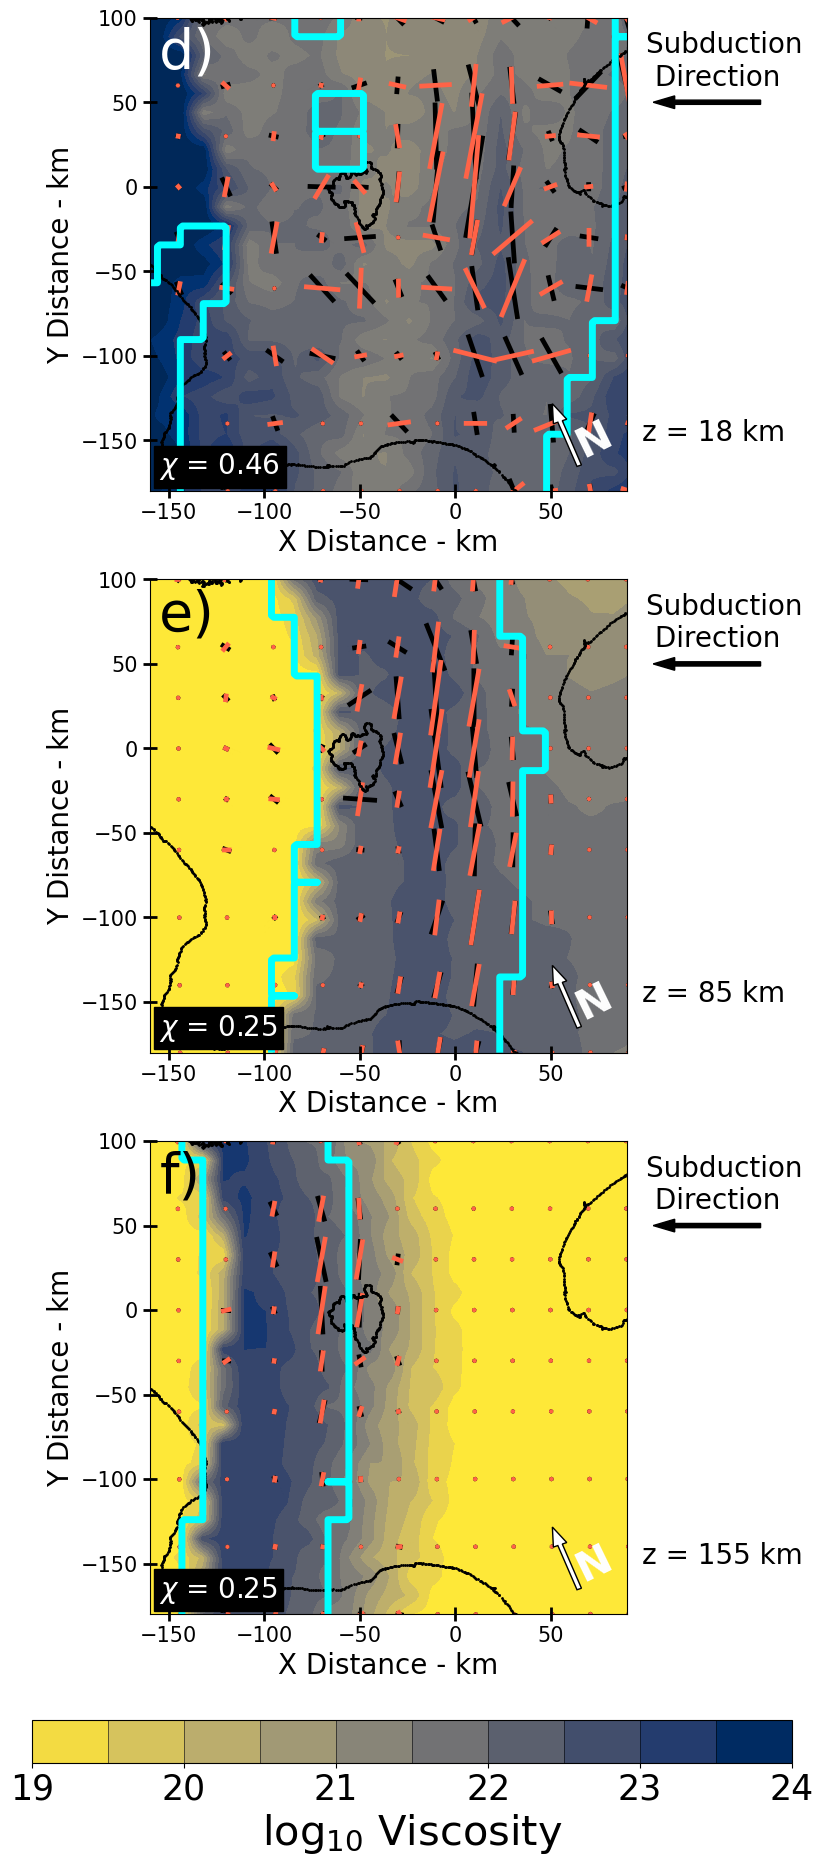

In [6]:
# These values come from Donna's Data File
azimuth = 132.0
center = [176.3500, -39.0800]
orientation = 'xyz'

values_for_loop = np.array([18, 85, 155])
dry_label_letter = np.array(["a)", "b)", "c)"])
wet_label_letter = np.array(["d)", "e)", "f)"])
letter_colours = np.array(['white', 'black', 'black'])
contour_levels = np.linspace(19, 24, 11)

wet_model = False
if "WET" in model_path:
    wet_model = True

fig = plt.figure(dpi=100, figsize=(8, 17))
for i in range(len(values_for_loop)):
    plt.subplot(3, 1, i+1)
    orientation = 'z'
    value_for_slice = values_for_loop[i]
    slice_latitude, slice_longitude, \
    slice_X, slice_Y, slice_Z, \
    slice_velocity, slice_azimuth, slice_mag = LPO.slice_donna_data(data, orientation, value_for_slice)

    # Extract the particle LPO from ASPECT, and project it to global cartesian coordinates
    ASPECT_cart, ASPECT_lpo, Donna_cart = LPO.global_cartesian_anisotropy(particle_solution[:, 0], particle_solution[:, 1], particle_solution[:, 2], \
                                                                          total_lpo_e1_axis, slice_longitude, slice_latitude, slice_Z)

    # Project coordinates to the local cartesian coordinate system
    ASPECT_local_x, ASPECT_local_y = LPO.local_cartesian_coordinates(ASPECT_cart[:, 0], ASPECT_cart[:, 1], ASPECT_cart[:, 2], total_lpo_e1_axis, azimuth, center, orientation)
    Donna_local_x, Donna_local_y = LPO.local_cartesian_coordinates(Donna_cart[:, 0], Donna_cart[:, 1], Donna_cart[:, 2], total_lpo_e1_axis, azimuth, center, orientation)

    xy_ASPECT_length = np.sqrt(1 - ASPECT_lpo[:, 2]**2)
    ASPECT_azimuth = np.arccos(ASPECT_lpo[:, 0] / xy_ASPECT_length)

    x_component = np.cos(np.deg2rad(azimuth - slice_azimuth))
    y_component = np.sin(np.deg2rad(azimuth - slice_azimuth))

    ASP_x_component = ASPECT_lpo[:, 0] * np.cos(np.deg2rad(azimuth) - ASPECT_azimuth)
    ASP_y_component = ASPECT_lpo[:, 1] * np.sin(np.deg2rad(azimuth) - ASPECT_azimuth)
    
    ASP_magnitude = np.sqrt(ASP_x_component**2 + ASP_y_component**2)

    ASP_x_component *= 1/ASP_magnitude
    ASP_y_component *= 1/ASP_magnitude

    padding = 3.
    slice_local_x, slice_local_y, slice_local_z, slice_local_visc = LPO.slice_ASPECT(subset_local_x, subset_local_y, subset_local_z, \
                                                                                     subset_local_visc, orientation, value_for_slice, padding)
    
    slice_local_x, slice_local_y, slice_local_z, slice_local_stress = LPO.slice_ASPECT(subset_local_x, subset_local_y, subset_local_z, \
                                                                                       subset_local_stress, orientation, value_for_slice, padding)
    slice_local_stress[np.where(slice_local_stress < np.log10(330e6))] = 0
    slice_local_stress[np.where(slice_local_stress >= np.log10(330e6))] = 1
    
    ASP_angle = np.arctan(ASP_x_component / ASP_y_component)
    donna_angle = np.arctan(x_component / y_component)
    angle_misfit = np.sin(np.abs(abs(ASP_angle) - abs(donna_angle)))
    total_misfit = np.average(angle_misfit, weights=slice_mag)

    if orientation == 'z':
        uniform_x = np.linspace(np.min(slice_local_x), np.max(slice_local_x), 26)
        uniform_z = np.linspace(-np.min(slice_local_y), -np.max(slice_local_y), 26)
        full_X, full_Z = np.meshgrid(uniform_x, uniform_z, indexing='ij')
        full_visc = full_Z * 0
        full_stress = full_Z * 0

        spherical_slice_KDTree = KDTree(np.c_[slice_local_x, -slice_local_y])

    for j in range(len(full_X)):
        for k in range(len(full_Z[0])):
            dd, tree_index = spherical_slice_KDTree.query([full_X[j][k], full_Z[j][k]], k=1)
            full_visc[j][k] = slice_local_visc[tree_index]
            full_stress[j][k] = slice_local_stress[tree_index]

    if orientation == 'z':
        interp_visc = RegularGridInterpolator((uniform_x, uniform_z), full_visc)
        interp_stress = RegularGridInterpolator((uniform_x, uniform_z), full_stress)
        highres_x = np.linspace(np.min(slice_local_x), np.max(slice_local_x), 251)
        highres_z = np.linspace(-np.min(slice_local_y), -np.max(slice_local_y), 251)
        highres_X, highres_Z = np.meshgrid(highres_x, highres_z, indexing='ij')
        pts = np.array([np.ravel(highres_X), np.ravel(highres_Z)]).T
        highres_visc = interp_visc(pts)
        highres_stress = interp_stress(pts)
        highres_visc[np.where(highres_visc <= 19)] = 19
        
        plt.contourf(highres_X, highres_Z, highres_visc.reshape(np.shape(highres_X)), vmin=19, \
                    vmax=24, cmap='cividis_r', levels=10)
        if wet_model:
            plt.contour(highres_X, highres_Z, highres_stress.reshape(np.shape(highres_X)), colors='cyan', \
                        levels=0, linewidths=5)
            
        plt.quiver(Donna_local_x, Donna_local_y, \
                   x_component, y_component, headwidth=1, width=0.01, headlength=0, scale=1/((slice_mag + 1e-10)/50), \
                   pivot='mid', color='black', label='Data', linewidth=0.5)
        
        plt.quiver(Donna_local_x, Donna_local_y, \
                   ASP_x_component, ASP_y_component, headwidth=1, width=0.01, headlength=0, scale=1/((slice_mag + 1e-10)/50), \
                   pivot='mid', color='tomato', label='ASPECT')
        
        plt.scatter(coast_local_x, -coast_local_y, s=1, edgecolor='black', facecolor='black')
        
        plt.xlim(-160, 90)
        plt.ylim(-180, 100)
        plt.xlabel('X Distance - km', fontsize=20)
        plt.ylabel('Y Distance - km', fontsize=20)
        plt.tick_params(axis='y', labelsize=15, direction='inout', length=10, width=2)
        plt.tick_params(axis='x', labelsize=15, direction='inout', length=10, width=2)
        plt.text(-155, -170, "$\chi$ = " + str(np.round(total_misfit, 2)), color='white', fontsize=20, backgroundcolor='black')
        plt.text(100, 60, "Subduction \n Direction", color='black', fontsize=20)
        plt.arrow(160, 50, -45, 0, color='black', width=2.5, clip_on=False)
        plt.arrow(65, -165, 15*(0 + np.cos(np.deg2rad(azimuth))), \
                  (1 + np.sin(np.deg2rad(azimuth)))*15, width=2.5, edgecolor='black', facecolor='white', zorder=100000)
        plt.text(60, -160, 'N', fontsize=30, color='white', rotation=26, fontweight='bold')
        if wet_model:
            plt.text(-155, 70, wet_label_letter[i], color=letter_colours[i], fontsize=40)
        else:
            plt.text(-155, 70, dry_label_letter[i], color=letter_colours[i], fontsize=40)
            
        plt.text(98, -150, "z = " + str(values_for_loop[i]) + " km", color='black', fontsize=20)
        if i == 1:
            im = plt.contourf(highres_X, highres_Z, highres_visc.reshape(np.shape(highres_X)), vmin=19, \
                  vmax=24, cmap='cividis_r', levels=contour_levels, zorder=0)
            cb_ax = fig.add_axes([0, -0.04, 0.95, 0.025])
            cbar = fig.colorbar(im,orientation='horizontal', cax=cb_ax, drawedges=True, ticks=np.array([19, 20, 21, 22, 23, 24]))
            cbar.ax.tick_params(labelsize=25) 
            cbar.set_label(label='log$_{10}$ Viscosity', size=30)

plt.tight_layout()
if wet_model:
    plt.savefig('wet_LPO_cross_sections.png', bbox_inches='tight')
else:
    plt.savefig('dry_LPO_cross_sections.png', bbox_inches='tight')
plt.show()        

# This calculates the error for each depth slice, for use in creating the error vs depth plot

In [14]:
# This loads in Donna's data along a plane specified by orientation, and a constant value in that plane
# specified with constant_value
massive_misfit = 0
depth_misfit = np.empty(0)
values_for_loop = np.array([0, 4, 11, 18, 25, 32, 40, 50, 65, 85, 105, 130, 155, 185])

wet_model = False
if "WET" in model_path:
    wet_model = True

for i in range(len(values_for_loop)):
    orientation = 'z'
    value_for_slice = values_for_loop[i]
    slice_latitude, slice_longitude, \
    slice_X, slice_Y, slice_Z, \
    slice_velocity, slice_azimuth, slice_mag = LPO.slice_donna_data(data, orientation, value_for_slice)

    # Extract the particle LPO from ASPECT, and project it to global cartesian coordinates
    ASPECT_cart, ASPECT_lpo, Donna_cart = LPO.global_cartesian_anisotropy(particle_solution[:, 0], particle_solution[:, 1], particle_solution[:, 2], \
                                                                          total_lpo_e1_axis, slice_longitude, slice_latitude, slice_Z)

    # These values came from the file containing Donna's Data
    center = [176.3500, -39.0800]
    azimuth = 132.0

    # Project coordinates to the local cartesian coordinate system
    ASPECT_local_x, ASPECT_local_y = LPO.local_cartesian_coordinates(ASPECT_cart[:, 0], ASPECT_cart[:, 1], ASPECT_cart[:, 2], total_lpo_e1_axis, azimuth, center, orientation)
    Donna_local_x, Donna_local_y = LPO.local_cartesian_coordinates(Donna_cart[:, 0], Donna_cart[:, 1], Donna_cart[:, 2], total_lpo_e1_axis, azimuth, center, orientation)

    xy_ASPECT_length = np.sqrt(1 - ASPECT_lpo[:, 2]**2)
    ASPECT_azimuth = np.arccos(ASPECT_lpo[:, 0] / xy_ASPECT_length)

    x_component = np.cos(np.deg2rad(132 - slice_azimuth))
    y_component = np.sin(np.deg2rad(132 - slice_azimuth))

    ASP_x_component = ASPECT_lpo[:, 0] * np.cos(np.deg2rad(132) - ASPECT_azimuth)
    ASP_y_component = ASPECT_lpo[:, 1] * np.sin(np.deg2rad(132) - ASPECT_azimuth)
    
    ASP_magnitude = np.sqrt(ASP_x_component**2 + ASP_y_component**2)

    ASP_x_component *= 1/ASP_magnitude
    ASP_y_component *= 1/ASP_magnitude

    ASP_angle = np.arctan(ASP_x_component / ASP_y_component)
    donna_angle = np.arctan(x_component / y_component)
    angle_misfit = np.sin(np.abs(abs(ASP_angle) - abs(donna_angle)))
    total_misfit = np.average(angle_misfit, weights=slice_mag)
    depth_misfit = np.append(depth_misfit, total_misfit)
    massive_misfit += total_misfit
    print(total_misfit, values_for_loop[i])
massive_misfit = massive_misfit / len(values_for_loop)

0.4744177527940029 0
0.4362845273273233 4
0.45400145017236615 11
0.46451306488926797 18
0.4077557280479984 25
0.41319831348180797 32
0.39803965303065586 40
0.494153810895552 50
0.4530002471467303 65
0.25108703823391276 85
0.22600645771915207 105
0.274949840758327 130


/var/folders/zw/0t9y_fkn22l4df48w2pgzd280000gn/T/ipykernel_93428/2985506936.py:45: RuntimeWarning: divide by zero encountered in divide
  donna_angle = np.arctan(x_component / y_component)


0.24606826803267 155
0.33960032356633196 185
